⚠️Clone the repository to use all the functions needed by the main code⚠️
---





In [1]:
try:
    import google.colab
    mode = 'colab'
except:
    mode = 'local'

if mode == 'colab':
    !git clone "https://github.com/cybernetic-m/nn-project.git"
    !pip install hydra-core --upgrade convkan
else:
    print("You are running locally!")

You are running locally!


# IMPORT AND INITIALIZATION

In [13]:
# Import for config.yaml file
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import random

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from torch.optim.lr_scheduler import ReduceLROnPlateau

if mode == 'colab':
    sys.path.append('/content/nn-project/dataloader')
    sys.path.append('/content/nn-project/model')
    sys.path.append('/content/nn-project/module')
    sys.path.append('/content/nn-project/training')
    sys.path.append('/content/nn-project/testing')
    from preprocessing import Preprocessing
    import utils
    import dataset
    from ctim import CTIM
    from train import *
    from test import *
 

if mode == 'local':
    import dataloader.utils as utils
    import dataloader.dataset as dataset
    from dataloader.preprocessing import Preprocessing
    from model.ctim import CTIM
    from training.train import train as train
    from testing.test import test as test


Reproducibility

In [3]:
# Set the seed
seed = 10

# Set seed for torch, numpy and random libraries
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the devide mode on GPU (if available CUDA for Nvidia and  MPS for Apple Silicon) or CPU
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


## Download and Split Dataset

In [4]:
link_dataset = "https://drive.google.com/file/d/1nzKBta2M3khw7Ql_S7atYg-H-bWDiOxr/view?usp=drive_link"
gdrive_link = "https://drive.google.com/uc?export=download&id="

if mode == 'colab':
    destination_dir = "/content/emovo.zip"
    extract_dir = '/content/dataset'
    emovo_dir = '/content/dataset/EMOVO'
    emovo_split_dir = '/content/dataset/EMOVO_split'
elif mode == 'local':
    destination_dir = "./emovo.zip"
    extract_dir = "./dataset"
    emovo_dir = "./dataset/EMOVO"
    emovo_split_dir = './dataset/EMOVO_split'

utils.download_dataset(link_dataset, destination_dir, gdrive_link, extract_dir)

utils.dataset_split(emovo_dir, extract_dir, 0.7, 0.2, 0.1)


Dataset already downloaded
Dataset already unzipped


# Data Augmentation

In [5]:
preprocessing = Preprocessing(device=device)

utils.augment_data(emovo_split_dir, extract_dir, preprocessing, device)

The augmented dataset already exist!


## Dataset Exploration

In [6]:
train_path = os.path.join(extract_dir, 'EMOVO_split', 'train')
test_path = os.path.join(extract_dir, 'EMOVO_split', 'test')
val_path = os.path.join(extract_dir, 'EMOVO_split', 'val')

train_dataset = dataset.EMOVO_Dataset(train_path, False, device=device)
test_dataset = dataset.EMOVO_Dataset(test_path, False, device=device)
val_dataset = dataset.EMOVO_Dataset(val_path, False, device=device)

train_aug_path = os.path.join(extract_dir, 'EMOVO_aug', 'train')
test_aug_path = os.path.join(extract_dir, 'EMOVO_aug', 'test')
val_aug_path = os.path.join(extract_dir, 'EMOVO_aug', 'val')

train_aug_dataset = dataset.EMOVO_Dataset(train_aug_path, device=device)
test_aug_dataset = dataset.EMOVO_Dataset(test_aug_path, device=device)
val_aug_dataset = dataset.EMOVO_Dataset(val_aug_path, device=device)

fixed a mono track: rab-f1-b1.wav


Example of audio

Tensor of shape: torch.Size([2, 122880]) Sample Rate: 48000
Class: gio 



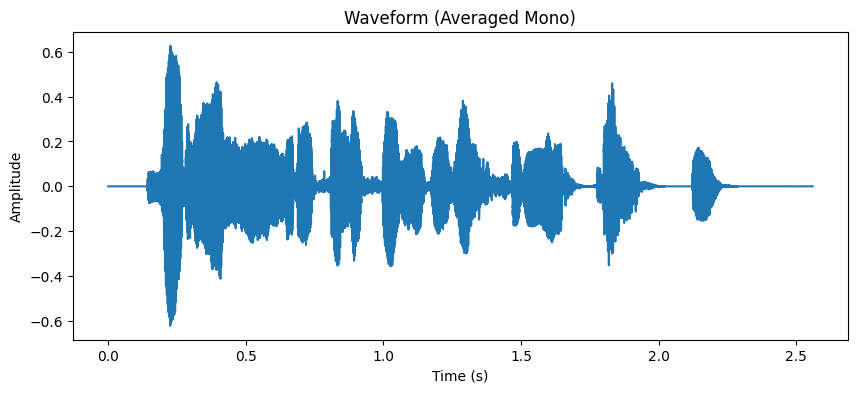

In [7]:
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
random_num = random.randint(1, train_dataset.__len__())
data, label = train_dataset[random_num]

print("Tensor of shape:",data[0].shape, "Sample Rate:", data[1])
print("Class:", classes[label], "\n")

# Waveform
# Compute the average of both channels to get a mono waveform
mono_waveform = data[0].mean(dim=0)
num_samples = mono_waveform.shape[0]
sample_rate = data[1]
time_axis = np.linspace(0, num_samples / sample_rate, num_samples)

# Play the audio
display(Audio(mono_waveform.cpu().numpy(), rate=sample_rate))

# Plot the averaged (mono) waveform
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mono_waveform.cpu().numpy())
plt.title('Waveform (Averaged Mono)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



Example of augmented audio

In [8]:
# TO DO

Data distribution

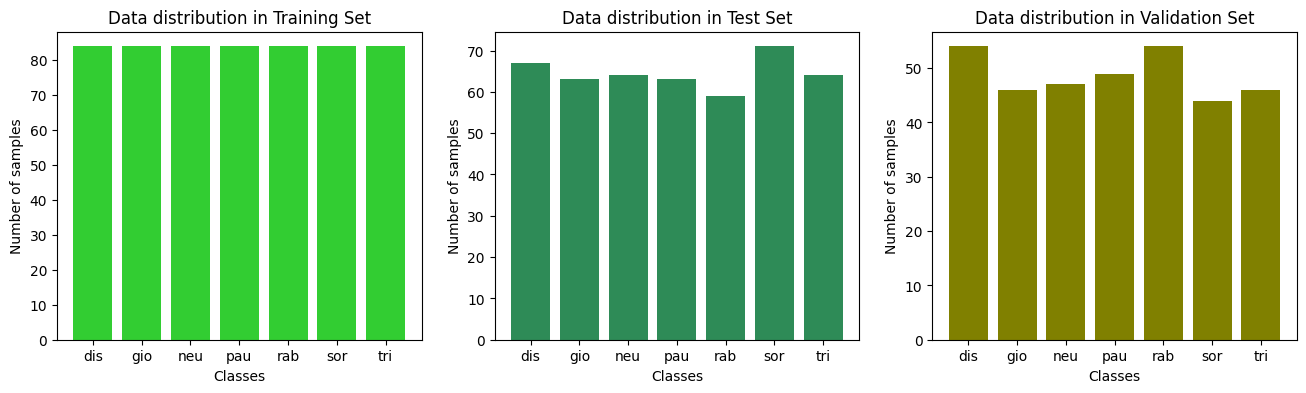

In [9]:
train_counts = train_dataset.get_info()
test_counts = test_dataset.get_info()
val_counts = val_dataset.get_info()
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']


fig, ax = plt.subplots(1,3, figsize=(16, 4))

ax[0].bar(classes, train_counts, color='limegreen')
ax[0].set_title("Data distribution in Training Set")
ax[0].set_xlabel("Classes")
ax[0].set_xticks(ticks=range(7), labels=classes)
ax[0].set_ylabel("Number of samples")

ax[1].bar(classes, test_counts, color='seagreen')
ax[1].set_title("Data distribution in Test Set")
ax[1].set_xlabel("Classes")
ax[1].set_xticks(ticks=range(7), labels=classes)
ax[1].set_ylabel("Number of samples")

ax[2].bar(classes, val_counts, color='olive')
ax[2].set_title("Data distribution in Validation Set")
ax[2].set_xlabel("Classes")
ax[2].set_xticks(ticks=range(7), labels=classes)
ax[2].set_ylabel("Number of samples")
plt.show()

Data augmented distribution

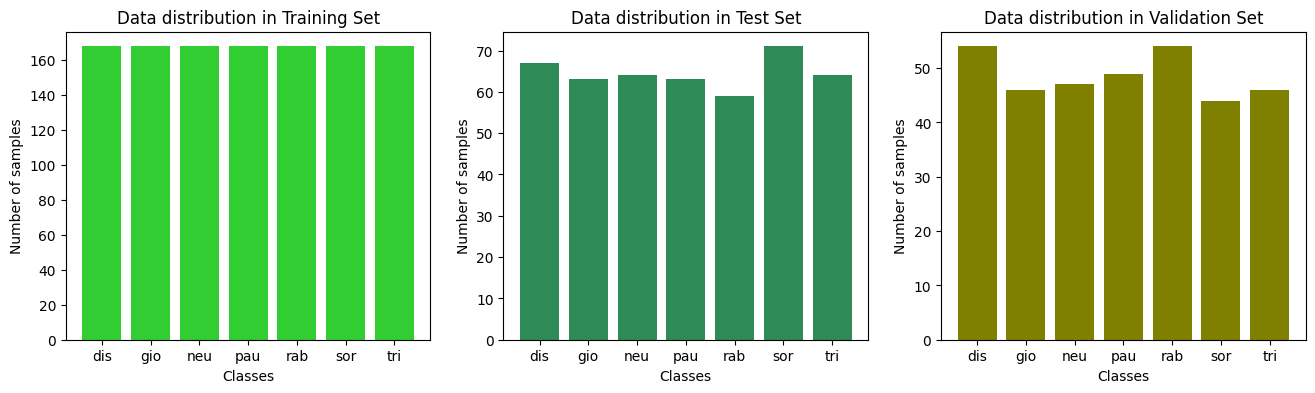

In [10]:
train_aug_counts = train_aug_dataset.get_info()
test_aug_counts = test_aug_dataset.get_info()
val_aug_counts = val_aug_dataset.get_info()
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']


fig, ax = plt.subplots(1,3, figsize=(16, 4))

ax[0].bar(classes, train_aug_counts, color='limegreen')
ax[0].set_title("Data distribution in Training Set")
ax[0].set_xlabel("Classes")
ax[0].set_xticks(ticks=range(7), labels=classes)
ax[0].set_ylabel("Number of samples")

ax[1].bar(classes, test_aug_counts, color='seagreen')
ax[1].set_title("Data distribution in Test Set")
ax[1].set_xlabel("Classes")
ax[1].set_xticks(ticks=range(7), labels=classes)
ax[1].set_ylabel("Number of samples")

ax[2].bar(classes, val_aug_counts, color='olive')
ax[2].set_title("Data distribution in Validation Set")
ax[2].set_xlabel("Classes")
ax[2].set_xticks(ticks=range(7), labels=classes)
ax[2].set_ylabel("Number of samples")
plt.show()

# HYDRA INITIALIZATION

In [11]:
# Check if Hydra is initialized
if GlobalHydra().is_initialized():
    # Clear the Hydra instance if it is initialized
    GlobalHydra.instance().clear()
    print("Hydra instance was initialized and has been cleared.")
else:
    # Initialize
    print("Hydra now initialized!")

# Initialization and Load configuration
if mode == 'local':
  initialize(config_path="./conf", job_name="notebook_nn_exam", version_base=None)
  cfg = compose(config_name="config")

elif mode == 'colab':
  initialize(config_path="./nn-project/conf", job_name="notebook_nn_exam", version_base=None)
  cfg = compose(config_name="config")


Hydra now initialized!


In [12]:
# Load the hyperparameters of the model
DROPOUT_RATE = cfg.model.dropout_rate
KERNEL_SIZE = cfg.model.kernel_size
N_TAB = cfg.model.n_temporal_aware_block
N_FILTER = cfg.model.n_filter
NUM_FEATURES = cfg.model.num_features
TAB_CONT = cfg.model.tab_cont
CONT = cfg.model.cont
USE_KAN = cfg.model.use_kan
OMEGA_0 = cfg.model.omega_0
IS_SIREN = cfg.model.is_siren

model = CTIM(
    kernel_size=KERNEL_SIZE, 
    dropout_rate=DROPOUT_RATE, 
    n_temporal_aware_block=N_TAB, 
    n_filter=N_FILTER, 
    in_channels=1,
    tab_cont=TAB_CONT,
    cont=CONT,
    num_features=NUM_FEATURES,
    num_classes = 7,
    use_kan = USE_KAN,
    omega_0=OMEGA_0,
    is_siren=IS_SIREN,
    device=device
)

# TRAINING

In [13]:
# Load the hyperparameters for training
EPOCHS = cfg.train.num_epochs
BATCH_SIZE = cfg.train.batch_size
LEARNING_RATE = cfg.train.learning_rate
OPTI = cfg.train.optimizer
EARLY_STOPPING = cfg.train.early_stopping
PATIENCE = cfg.train.patience
LR_SCHEDULER = cfg.train.lr_scheduler
LABEL_SMOOTHING = cfg.train.label_smoothing

# Initialization of the metrics' dictionary
training_metrics_dict = {
    "model" : [model.model_name],
    "epoch": [],
    "loss": [],
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": [],
}
validation_metrics_dict = {
    "model" : [model.model_name],
    "epoch": [],
    "loss": [],
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": [],
}

train_dataset = dataset.EMOVO_Dataset(train_path, True, device=device)
test_dataset = dataset.EMOVO_Dataset(test_path, True, device=device)
val_dataset = dataset.EMOVO_Dataset(val_path, True, device=device)

# Dataloader initialization for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)#, collate_fn=utils.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)#, collate_fn=utils.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)#, collate_fn=utils.collate_fn)

# Definition of the Categorical Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss(label_smoothing = LABEL_SMOOTHING) 

# Definition of the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)#, weight_decay=WEIGHT_DECAY)

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER, patience=5)

train(EPOCHS, training_metrics_dict, validation_metrics_dict, train_dataloader, val_dataloader, model, loss_fn, optimizer, lr_scheduler, cfg)

EPOCH 1:
TRAIN:
accuracy: 14.63, precision: 14.63, recall: 14.63, f1-score: 14.63
VALIDATION:
accuracy: 20.00, precision: 20.00, recall: 20.00, f1-score: 20.00
LOSS train 1.9601869583129883 valid 1.9476338624954224


OSError: [WinError 123] La sintassi del nome del file, della directory o del volume non è corretta: 'c:\\Users\\User\\Downloads\\informatica\\magistrale\\nn\\nn-project\\training\\results/ctim2024-10-01_13:11:42'

# TESTING

In [ ]:
# Path to the model.pt
model_path = './testing/model.pt'

# Batch size of the dataloader
BATCH_SIZE = cfg.train.batch_size

# Initialization of the dataloader
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)#, collate_fn=utils.collate_fn)

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Initialization of the test metrics dictionary
test_metrics_dict = {
    "model" : [model.model_name],
    "epoch": [],
    "loss": [],
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": [],
}

cm = test(
    model,
    model_path,
    test_dataloader,
    test_metrics_dict,
    loss_fn
)

/Users/cyber_m/Desktop/Neural Network/nn-project/model/ctim.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.device('cpu

loaded: ./testing/model.pt
accuracy: 17.09, precision: 17.09, recall: 17.09, f1-score: 17.09
Metrics saved: /Users/cyber_m/Desktop/Neural Network/nn-project/testing/tim_test_metrics.json


# Loss and Accuracy (Training and Validation)

In [ ]:
actual_dir = './training/results'
# TO DO add an intermidiate path with the directories of best models (1 for each possibility)
path_training_metrics = actual_dir + '/training_metrics.json'
path_validation_metrics = actual_dir+ '/validation_metrics.json'

# load the dictionary {'model': [model_name], 'epoch': [1, 2 ...], 'loss': [1.9, 1.8 ...], 'accuracy': [0.6, 0.7, ...], 'recall': [0.2, 0.3, ...], 'precision': [0.3, 0.4, ...], 'f1-score': [0.5, 0.6, ...]}
data_training = utils.load_metrics(path_training_metrics)
data_validation = utils.load_metrics(path_training_metrics)

# Load the epochs, loss and accuracy in training and validation for the plots
epochs = data_training['epoch']
training_loss = data_training['loss']
training_accuracy = data_training['accuracy']

validation_loss = data_validation['loss']
validation_accuracy = data_validation['accuracy']

# Plot section
# 1st Subplot => Loss in Training and Validation
# 2nd Subplot => Accuracy in Training and Validation
utils.plot_loss_acc(epochs, training_loss, validation_loss, training_accuracy, validation_accuracy)

# Confusion Matrix

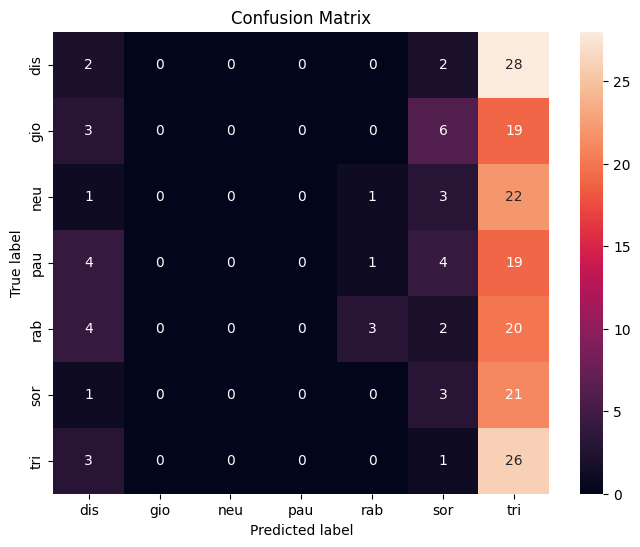

In [ ]:
# Plot the confusion Matrix

class_names = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
utils.plot_confusion_matrix(cm, class_names, cmap='rocket')